#Beam Element - This notebook computes the mass matrix and internal forces and outputs them for later use


1. 2D beam generalized coordinates (1 rotation 2 displacements) (Reduced dimensions so all matricies are subsequently invertible, Mii = 0 if some dof's are accounted for but  unused)
2. Interpolation of roataion matricies WITHOUT orthogonalization (sympy struggling with too much algebra)
3. circular cross-section with radius 'r'

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import pickle

from scipy import linalg
from sympy import mpmath
from sympy import cos, sin
from sympy import lambdify

from IPython.display import display
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
np.set_printoptions(precision=4,suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline

#### Define Needed Functions

In [2]:
def Skew_sym(v):
    """
    This function returns the skew symetric matrix 
    of the vector 'v' to affect the cross product of 'v'x'u'
    """
    v_matrix = sym.Matrix([[  0 , -v[2]],
                          [v[2],     0]])
    return v_matrix

In [3]:
def Axial_sym(A):
    '''
    This funtcion returns the vector of the skew-symmectric matrix in 2D
    '''
    a_vec = 1/2*sym.Matrix([A[1,0] - A[0,1]])
    return a_vec

In [4]:
def Rotate_sym(theta):
    """
    This function returns the symbolic rotation matrix 
    for the simple 2D-rotation about the third axis
    """
    R = sym.Matrix([[cos(theta),-sin(theta)],
                    [sin(theta), cos(theta)]])
    return R

#### Define symbolic quantites

In [5]:
# symbolic system parameters 
E, G, I, A, rho, x, l, r, g  = sym.symbols('E G I A rho x l r g')

# Kinematic values of previos nodes (generic)
# e.g., omega_node  = omega + qdot
theta = sym.Matrix(['theta_1','theta_2'])
omega = sym.Matrix(['omega_1','omega_2'])
alpha = sym.Matrix(['alpha_1','alpha_2'])

# coordinates of the point in the 2D cross-section
# of nodes one and two 
s1 = sym.Matrix(['r_2','r_3'])
s2 = sym.Matrix(['r_2','r_3'])
s = sym.Matrix.vstack(s1,s2)

# generalized coordinates
# one rotation and two displacements per-node (two nodes per element)
# in this version generalzied speeds are qdots
q = sym.Matrix(sym.symarray('q',6))
qdot = sym.Matrix(sym.symarray('qdot',len(q)))
qddot = sym.Matrix(sym.symarray('qddot',len(q)))

# Deformations of Nodes (u's are not generalized speeds) 
u = sym.Matrix([q[1:3,0], q[4:6,0]])
udot = sym.Matrix([qdot[1:3,0], qdot[4:8,0]])
uddot = sym.Matrix([qddot[1:3,0], qddot[4:6,0]])

# display([q,qdot,qddot])
# display([u,udot,uddot])

### Needed Matrix Quantities

In [6]:
""" 
Some cheating here: 
q0,q3 and q0dot,q3dot are really theta_1j, theta_2j and omega_1j, omega_2j
"""
# angular position and velocity for 2D using relative coordinates
# the sum of the respective quantites of bodies 1 - bodyj-1 
# Kinematics are trivial for the planar case:
# theta_j, omega_j =  sum(q1 ... qj), sum(q1dot ... qjdot), j = 1 ... nbodies

R1 = Rotate_sym(q[0])
R2 = Rotate_sym(q[3])

# Only true for planar case
omega1_skew = Skew_sym([0,0,qdot[0]])
omega2_skew = Skew_sym([0,0,qdot[3]])

# Only true for planar case
alpha1_skew = Skew_sym([0,0,qddot[0]])
alpha2_skew = Skew_sym([0,0,qddot[3]])


# "spatial" rotation matrix
R = sym.Matrix.vstack(sym.Matrix.hstack(R1,sym.zeros(2)), \
                      sym.Matrix.hstack(sym.zeros(2),R2))

# "spatial" angular velocity matrix
Omega_skew = sym.Matrix.vstack(sym.Matrix.hstack(omega1_skew,sym.zeros(2)), \
                               sym.Matrix.hstack(sym.zeros(2),omega2_skew))

# "spatial" angular acceleration matrix
Alpha_skew = sym.Matrix.vstack(sym.Matrix.hstack(alpha1_skew,sym.zeros(2)), \
                               sym.Matrix.hstack(sym.zeros(2),alpha2_skew))
# display(Omega)

### Define Kinematics

In [7]:
# Define position of element endpoints (nodes)
# x0 = 0 y0 = 0 x0_vec = [0,0]

# Define Locations of Centroid of nodes
# Vectors with no basis indicator are expressed in 'N'
# X0_B = sym.Matrix(['0','0','l','0'])
# X0 = R*X0_B
# rp = sym.simplify(X0 + u + R*s)

# print('r = ')
# display(rp)

# Define velocity of element endpoints (nodes)
v = sym.simplify(udot + R*Omega_skew*s)
print('v = ')
display(v)

# Define acceleration of element endpoints (nodes)
a = sym.simplify(uddot + R*Omega_skew*Omega_skew*s + R*Alpha_skew*s)
print('\na = ')
display(a)

v = 


⎡-q̇₀⋅r₂⋅sin(q₀) - q̇₀⋅r₃⋅cos(q₀) + q̇₁⎤
⎢                                      ⎥
⎢q̇₀⋅r₂⋅cos(q₀) - q̇₀⋅r₃⋅sin(q₀) + q̇₂ ⎥
⎢                                      ⎥
⎢-q̇₃⋅r₂⋅sin(q₃) - q̇₃⋅r₃⋅cos(q₃) + q̇₄⎥
⎢                                      ⎥
⎣q̇₃⋅r₂⋅cos(q₃) - q̇₃⋅r₃⋅sin(q₃) + q̇₅ ⎦


a = 


⎡                                            2                 2           ⎤
⎢-q̈₀⋅r₂⋅sin(q₀) - q̈₀⋅r₃⋅cos(q₀) + q̈₁ - q̇₀ ⋅r₂⋅cos(q₀) + q̇₀ ⋅r₃⋅sin(q₀)⎥
⎢                                                                          ⎥
⎢                                           2                 2            ⎥
⎢q̈₀⋅r₂⋅cos(q₀) - q̈₀⋅r₃⋅sin(q₀) + q̈₂ - q̇₀ ⋅r₂⋅sin(q₀) - q̇₀ ⋅r₃⋅cos(q₀) ⎥
⎢                                                                          ⎥
⎢                                            2                 2           ⎥
⎢-q̈₃⋅r₂⋅sin(q₃) - q̈₃⋅r₃⋅cos(q₃) + q̈₄ - q̇₃ ⋅r₂⋅cos(q₃) + q̇₃ ⋅r₃⋅sin(q₃)⎥
⎢                                                                          ⎥
⎢                                           2                 2            ⎥
⎣q̈₃⋅r₂⋅cos(q₃) - q̈₃⋅r₃⋅sin(q₃) + q̈₅ - q̇₃ ⋅r₂⋅sin(q₃) - q̇₃ ⋅r₃⋅cos(q₃) ⎦

### Compute the Mass Matrix

In [9]:
# Define shape function for element with one node at each end
h = sym.symarray('h', 2)

h[0] = sym.Rational(1,2)*(1 - x)
h[1] = sym.Rational(1,2)*(1 + x)

# Compute shape function matrix
H = sym.Matrix([h[0]*sym.eye(2), h[1]*sym.eye(2)]).T
dHdx = H.diff(x)
# print('\nH = ')
# display(H)

# Define velocity of any point 
# Rp = H*rp
# print('\nR = ')
# display(Rp)

# Define velocity of any point 
Vp = H*v
# print('\nV = ')
# display(Vp)

# Define velocity of any point 
Ap = H*a
# print('\nA = ')
# display(Accel)

# Compute partial velocities of the nodes
Vr = sym.simplify(sym.Matrix([[sym.diff(Vp,qdot) for Vp in Vp] for qdot in qdot]).T)
# v_r = H
# print('\nVr = ')
# display(Vr)
# print(Vr.shape)

# Compute mass matrix
M = sym.simplify(sym.factor(sym.Matrix(
            [[sym.expand(sym.integrate(Vr[:,i].dot(Ap)*rho,('r_2',0,r),('r_3',0,r),(x,0,l))).coeff(qddot[j]) 
              for i in range(len(qddot))] for j in range(len(qddot))])))

In [10]:
# # print('\nM = \n')
# # display(M)

# print('M_11 = ')
# display(M[0:3,0:3])
# print('\nM_22 = ')
# display(M[3:6,3:6])
# print('\nM_12 = ')
# display(M[0:3,3:6])
# print('\nM_21.T = ')
# display(M[3:6,0:3].T)

### Compute Internal forces 

#### 1. Transverse (Bending) Strain

In [11]:
# Orthogonal Matricies Not Extracted to Simplify Algebra
R_interp = sym.simplify(H*sym.Matrix([R1,R2]))
dT = sym.simplify(H.diff(x)*sym.Matrix([R1,R2]))
kappa = sym.simplify(sym.Matrix([Axial_sym(dT*R_interp.T),'0','0','0']))
# display(kappa)

In [12]:
R_interp

⎡(-x + 1)⋅cos(q₀)   (x + 1)⋅cos(q₃)  (x - 1)⋅sin(q₀)   (x + 1)⋅sin(q₃) ⎤
⎢──────────────── + ───────────────  ─────────────── - ─────────────── ⎥
⎢       2                  2                2                 2        ⎥
⎢                                                                      ⎥
⎢(-x + 1)⋅sin(q₀)   (x + 1)⋅sin(q₃)  (-x + 1)⋅cos(q₀)   (x + 1)⋅cos(q₃)⎥
⎢──────────────── + ───────────────  ──────────────── + ───────────────⎥
⎣       2                  2                2                  2       ⎦

#### 2. Longitudinal (Axial) Strian

In [20]:
# Define Locations of Centroid
x0_B = sym.Matrix(['x','0'])
x0 = R_interp*x0_B

# Define Newtonian Unit Vector x-dir
n1 = sym.Matrix(['1','0'])

# Interpolate Displacemnts
u_terp = H*u

# Derivatives w.r.t longitudinal beam coordinate
du = u_terp.diff(x)
dx0 = x0.diff(x)

# Compute axial strain
u_ax = (dx0 + du - R_interp*n1).simplify()
epsilon = sym.Matrix(['0', u_ax[0], '0', u_ax[1]])
# epsilon = u_ax
display(epsilon)

⎡                0                ⎤
⎢                                 ⎥
⎢  q₁   q₄   x⋅(cos(q₀) - cos(q₃))⎥
⎢- ── + ── - ─────────────────────⎥
⎢  2    2              2          ⎥
⎢                                 ⎥
⎢                0                ⎥
⎢                                 ⎥
⎢  q₂   q₅   x⋅(sin(q₀) - sin(q₃))⎥
⎢- ── + ── - ─────────────────────⎥
⎣  2    2              2          ⎦

In [21]:
display(epsilon.simplify())

None

#### 3. Compute Internal Forces $Q_e = -\frac{\partial U}{\partial e}$

In [22]:
"""
Note: Sympy bug! Integrating a matrix returns a vector!!!
"""
# Transverse strain energy
kappa_squared = (kappa.T*dHdx.T).dot(dHdx*kappa)
Ut = 1/2*sym.integrate(E*I*kappa_squared, (x,0,l))

G = E/2.6
C = sym.Matrix([[E*A, 0],[0, 5/6*G*A]])
Ul = 1/2*sym.integrate(epsilon.T*dHdx.T*R_interp*C*R_interp.T*dHdx*epsilon, (x,0,l))[0]

# Compute Total Energy
U = Ul + Ut

# Compute Internal Force Vector
Qe = sym.Matrix([sym.simplify(sym.expand(-sym.diff(U,qi))) for qi in q])

####4. Applied and body force vector

In [23]:
# Applied forces
# Gravity body force
fg = g*rho*sym.Matrix([0,-1])

# Applied torque (not considered at this time, no partial angular velocities)
# torque_app = sym.Matrix([0,0,tau_a])

# Compute beta
beta = sym.Matrix([sym.simplify(sym.integrate(Vr[:,j].dot(fg),('r_2',0,r),('r_3',0,r),(x,0,l)))
                   + qe for j,qe in zip(range(len(q)),Qe)])

# Just for debugging purposes
Fg = sym.Matrix([sym.simplify(sym.integrate(Vr[:,j].dot(fg),('r_2',0,r),('r_3',0,r),(x,0,l)))
                   for j in range(len(q))])

In [24]:
pickle.dump( M,    open( "gebf-mass-matrix.dump",   "wb" ) )
pickle.dump( beta, open( "gebf-force-vector.dump",  "wb" ) )
pickle.dump( U,    open( "gebf-strain-energy.dump", "wb" ) )
# pickle.dump(PE, open("potential_enrgy", "wb")) 

In [25]:
# M_sym    = pickle.load( open( "gebf-mass-matrix.dump",   "rb" ) )
# beta_sym = pickle.load( open( "gebf-force-vector.dump",  "rb" ) )
# U_sym    = pickle.load( open( "gebf-strain-energy.dump", "rb" ) )

In [26]:
M_func    = lambdify((E, A, I, r, rho, l, g, q),    M, "numpy")
beta_func = lambdify((E, A, I, r, rho, l, g, q), beta, "numpy")
U_func    = lambdify((E, A, I, r, rho, l, g, q),    U, "numpy")

In [27]:
# Debugging functions to trace source of error 
Qe_func    = lambdify((E, A, I, r, rho, l, g, q),    Qe, "numpy")
Fg_func    = lambdify((E, A, I, r, rho, l, g, q),    Fg, "numpy")
Ut_func    = lambdify((E, A, I, r, rho, l, g, q),    Ut, "numpy")
Ul_func    = lambdify((E, A, I, r, rho, l, g, q),    Ul, "numpy")
# e2_func    = lambdify((E, A, I, r, rho, l, g, q), epsilon_squared, "numpy")

In [28]:
beta_num = beta_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.zeros_like(q))
M_num    = M_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.zeros_like(q))
U_num    = U_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.zeros_like(q))

In [29]:
M11 = np.array(M_num[0:3,0:3])
M12 = np.array(M_num[0:3,3:6])
M21 = np.array(M_num[3:6,0:3])
M22 = np.array(M_num[3:6,3:6])

# For now use these definitions to cast Fic (constraint forces between GEBF elements) 
# into generalized constraint forces
gamma11 = np.eye(3)
gamma12 = np.zeros((3,3))
gamma22 = np.eye(3)
gamma21 = np.zeros((3,3))

# partition beta into lambda13 and lambda23
gamma13 = np.array(beta_num[0:3])
gamma23 = np.array(beta_num[3:6])


# Commonly inverted quantities
iM11 = np.linalg.inv(M11)
iM22 = np.linalg.inv(M22)
Gamma1 = np.linalg.inv(M11 - M12.dot(iM22.dot(M21)))
Gamma2 = np.linalg.inv(M22 - M21.dot(iM11.dot(M12)))

# Compute all terms of the two handle equations
z11 = Gamma1.dot(gamma11 - M12.dot(iM22.dot(gamma21)))
z12 = Gamma1.dot(gamma12 - M12.dot(iM22.dot(gamma22)))
z21 = Gamma2.dot(gamma21 - M21.dot(iM11.dot(gamma11)))
z22 = Gamma2.dot(gamma22 - M21.dot(iM11.dot(gamma12)))

z13 = Gamma1.dot(gamma13 - M12.dot(iM22.dot(gamma23))).reshape((3,1))
z23 = Gamma2.dot(gamma23 - M21.dot(iM11.dot(gamma13))).reshape((3,1))

In [30]:
beta_num

matrix([[-0.021 ],
        [ 0.    ],
        [-1.7553],
        [-0.0237],
        [ 0.    ],
        [-1.9793]])

In [31]:
print(z13)
print()
print(z23)

[[-0.  ]
 [-0.  ]
 [-9.81]]

[[ 0.  ]
 [ 0.  ]
 [-9.81]]


In [39]:
theta = np.linspace(0,2*np.pi,200)
q0GEBF = [np.array([theta,0,0,0,0,0]).reshape(6,1) for theta in theta]
q0GEBF[:][3] = q0GEBF[:][0]
Ul_theta1 = np.array([Ul_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0) for q0      in q0GEBF])
Ut_theta1 = np.array([Ut_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0) for q0      in q0GEBF])
Qe_theta1 = np.array([np.linalg.norm(Qe_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0)) for q0 in q0GEBF])
q0GEBF = [np.array([theta,0,0,0,0,0]).reshape(6,1) for theta in theta]          

# q0GEBF[:][3] = q0GEBF[:][0] 
Ul_theta2 = np.array([Ul_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0) for q0      in q0GEBF])
Ut_theta2 = np.array([Ut_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0) for q0      in q0GEBF])
Qe_theta2 = np.array([np.linalg.norm(Qe_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0)) for q0 in q0GEBF])                                                                   
                                                                                               
theta.tofile('theta.data')
Ul_theta1.tofile('strainEnergyAxial1_3.data')
Ul_theta2.tofile('strainEnergyAxial2_3.data')
Ut_theta1.tofile('strainEnergyBending1_3.data')
Ut_theta2.tofile('strainEnergyBending2_3.data')
Qe_theta1.tofile('bodyForces1_3.data')
Qe_theta2.tofile('bodyForces2_3.data')        

In [46]:
theta = np.fromfile('theta.data')
Ul_theta1_0 = np.fromfile('strainEnergyAxial1_0.data')
Ul_theta2_0 = np.fromfile('strainEnergyAxial2_0.data')
Ul_theta1   = np.fromfile('strainEnergyAxial1.data')
Ul_theta2   = np.fromfile('strainEnergyAxial2.data')
Ul_theta1_2 = np.fromfile('strainEnergyAxial1_2.data')
Ul_theta2_2 = np.fromfile('strainEnergyAxial2_2.data')
Ul_theta1_3 = np.fromfile('strainEnergyAxial1_3.data')
Ul_theta2_3 = np.fromfile('strainEnergyAxial2_3.data')

Ut_theta1_0 = np.fromfile('strainEnergyBending1_0.data')
Ut_theta2_0 = np.fromfile('strainEnergyBending2_0.data')
Ut_theta1   = np.fromfile('strainEnergyBending1.data')
Ut_theta2   = np.fromfile('strainEnergyBending2.data')
Ut_theta1_2 = np.fromfile('strainEnergyBending1_2.data')
Ut_theta2_2 = np.fromfile('strainEnergyBending2_2.data')
Ut_theta1_3 = np.fromfile('strainEnergyBending1_3.data')
Ut_theta2_3 = np.fromfile('strainEnergyBending2_3.data')

Qe_theta1_0 = np.fromfile('bodyForces1_0.data')
Qe_theta2_0 = np.fromfile('bodyForces2_0.data')
Qe_theta1   = np.fromfile('bodyForces1.data')
Qe_theta2   = np.fromfile('bodyForces2.data')
Qe_theta1_2 = np.fromfile('bodyForces1_2.data')
Qe_theta2_2 = np.fromfile('bodyForces2_2.data')
Qe_theta1_3 = np.fromfile('bodyForces1_3.data')
Qe_theta2_3 = np.fromfile('bodyForces2_3.data')

[None, None, None]

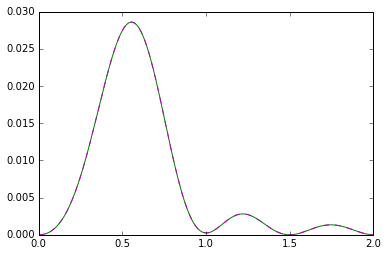

In [49]:
# plt.rc('lines', linewidth=1)
# ax.set_color_cycle(['c', 'm', 'y', 'k'])
# plt.plot(theta/np.pi, Ul_theta1  )          
# plt.plot(theta/np.pi, Ul_theta2  )
# plt.plot(theta/np.pi, Ul_theta1_2)
# plt.plot(theta/np.pi, Ul_theta2_2)

# plt.show()
# lines1 = plt.plot(theta/np.pi, Ul_theta1_0, 
#                   theta/np.pi, Ul_theta2_0,
#                   theta/np.pi, Ul_theta1, 
#                   theta/np.pi, Ul_theta2,
#                   theta/np.pi, Ul_theta1_2,
#                   theta/np.pi, Ul_theta2_2,
lines1 = plt.plot(theta/np.pi, Ul_theta1_3,
                  theta/np.pi, Ul_theta2_3)
                  
# l11, l21, l31, l41, l51, l61, l71, l81 = lines1
# plt.setp(l11, linewidth=1, color='r')  # line1 is thick and red
# plt.setp(l21, linewidth=1, color='b', linestyle='--')  # line2 is thicker and green
# plt.setp(l31, linewidth=1, color='c')  # line1 is thick and red
# plt.setp(l41, linewidth=1, color='k', linestyle='--')  # line2 is thicker and green
# plt.setp(l51, linewidth=1, color='g')  # line1 is thick and red
# plt.setp(l61, linewidth=1, color='m', linestyle='--')  # line2 is thicker and green
# plt.setp(l51, linewidth=1, color='g')  # line1 is thick and red
plt.setp(lines1[0], linewidth=1, color='g', )  # line2 is thicker and green
plt.setp(lines1[1], linewidth=1, color='m', linestyle='--')  # line2 is thicker and green


In [50]:
epsilon

⎡                0                ⎤
⎢                                 ⎥
⎢  q₁   q₄   x⋅(cos(q₀) - cos(q₃))⎥
⎢- ── + ── - ─────────────────────⎥
⎢  2    2              2          ⎥
⎢                                 ⎥
⎢                0                ⎥
⎢                                 ⎥
⎢  q₂   q₅   x⋅(sin(q₀) - sin(q₃))⎥
⎢- ── + ── - ─────────────────────⎥
⎣  2    2              2          ⎦

In [ ]:
Ul.simplify()

In [ ]:
# plt.rc('lines', linewidth=1)
# ax.set_color_cycle(['c', 'm', 'y', 'k'])
# plt.plot(theta/np.pi, Ul_theta1  )          
# plt.plot(theta/np.pi, Ul_theta2  )
# plt.plot(theta/np.pi, Ul_theta1_2)
# plt.plot(theta/np.pi, Ul_theta2_2)

# plt.show()
# lines1 = plt.plot(theta/np.pi, Ul_theta1_0, 
#                   theta/np.pi, Ul_theta2_0,
#                   theta/np.pi, Ul_theta1, 
#                   theta/np.pi, Ul_theta2,
#                   theta/np.pi, Ul_theta1_2,
#                   theta/np.pi, Ul_theta2_2,
lines2 = plt.plot(theta/np.pi, Ut_theta1_3,
                  theta/np.pi, Ut_theta2_3)
                  
# l11, l21, l31, l41, l51, l61, l71, l81 = lines1
# plt.setp(l11, linewidth=1, color='r')  # line1 is thick and red
# plt.setp(l21, linewidth=1, color='b', linestyle='--')  # line2 is thicker and green
# plt.setp(l31, linewidth=1, color='c')  # line1 is thick and red
# plt.setp(l41, linewidth=1, color='k', linestyle='--')  # line2 is thicker and green
# plt.setp(l51, linewidth=1, color='g')  # line1 is thick and red
# plt.setp(l61, linewidth=1, color='m', linestyle='--')  # line2 is thicker and green
# plt.setp(l51, linewidth=1, color='g')  # line1 is thick and red
plt.setp(lines2[0], linewidth=1, color='g', )  # line2 is thicker and green
plt.setp(lines2[1], linewidth=1, color='m', linestyle='--')  # line2 is thicker and green
